# Try out new chronos timeseries module

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm
import tsdb

Load model

In [ ]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-base",
  device_map="cuda",	
  torch_dtype=torch.bfloat16,
)
# pipeline = ChronosPipeline.from_pretrained(
#   r"C:\Users\eivin\.cache\huggingface\hub\models--amazon--chronos-t5-base",
#   device_map="cuda",	
#   torch_dtype=torch.bfloat16,
# )

## Helper functions

In [160]:
def load_model():
	pipeline = ChronosPipeline.from_pretrained(
	"amazon/chronos-t5-base",
	device_map="cuda",	
	torch_dtype=torch.bfloat16,
	)
	return pipeline
	
def predict(pipeline, timeseries, prediction_length=12):
	"""given a timeseries, predict with chronos model"""
	forecast = pipeline.predict(timeseries, prediction_length, num_samples=1)[0][0]  # shape [num_series, num_samples, prediction_length]
	return forecast

def visualize(timeseries, forecast, ground_truth=None, xlim=None, ylim=None):
	# visualize the forecast
	assert isinstance(timeseries, torch.Tensor) and isinstance(forecast, torch.Tensor), "timeseries and forecast should be numpy arrays"
	
	plt.figure(figsize=(8, 4))
	plt.plot(range(len(timeseries)), timeseries, color="royalblue", label="historical data")
	plt.plot(range(len(timeseries)-1, len(timeseries) - 1 + len(forecast)), forecast, color="tomato", label="forecast")
	if ground_truth is not None:
		plt.plot(range(len(timeseries)-1, len(timeseries) - 1 + len(ground_truth)), ground_truth, color="green", label="ground truth")
	if xlim is not None:
		plt.xlim(xlim)
	if ylim is not None:
		plt.ylim(ylim)
	plt.legend()
	plt.grid()
	plt.show()


def get_mse(y_true, y_pred):
	return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
	return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
	return np.sqrt(get_mse(y_true, y_pred))

def get_scores(y_true, y_pred):
	"""given true and predicted values, return mse, mae, rmse"""
	return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)


## Example task

In [ ]:
pipeline = load_model()
example_timeseries = torch.tensor(range(100), dtype=torch.float32)
forecast = predict(pipeline, example_timeseries)

In [ ]:
forecast

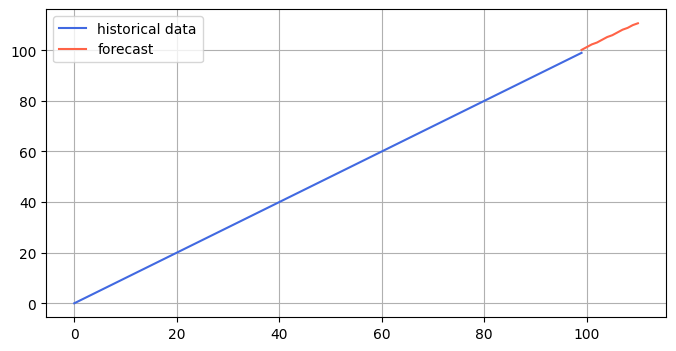

In [158]:
visualize(example_timeseries, forecast)


## Apply the model to real dataset

In [ ]:
pipeline = load_model()
data = tsdb.load('physionet_2012')
timeseries = data["X"]["Temp"].to_numpy()
physionet_2012_timeseries = timeseries[~np.isnan(timeseries)]

Test the model performance

In [ ]:
# now test the model. Given the last x values, predict the next y values, then we can calculate metrics like MSE, RMSE, MAE

CONTEXT_LENGTH = 200
PREDICTION_LENGTH = 5		


mse_scores, mae_scores, rmse_scores = [], [], []
for i in tqdm(range(0, len(physionet_2012_timeseries), CONTEXT_LENGTH)):
	if (i+CONTEXT_LENGTH+PREDICTION_LENGTH) > len(physionet_2012_timeseries):
		break
	prediction = predict(pipeline, torch.tensor(physionet_2012_timeseries[i:i+CONTEXT_LENGTH]), PREDICTION_LENGTH)
	ground_truth = physionet_2012_timeseries[i+CONTEXT_LENGTH:i+CONTEXT_LENGTH+PREDICTION_LENGTH]

	mse, mae, rmse = get_scores(ground_truth, prediction.numpy())
	mse_scores.append(mse), mae_scores.append(mae), rmse_scores.append(rmse)

In [ ]:
np.mean(mse_scores), np.mean(mae_scores), np.mean(rmse_scores)

In [ ]:
print("MAE:  ",round(np.mean(mae_scores), 2))
print("MSE:  ",round( np.mean(mse_scores), 2) )
print("RMSE: ",round( np.mean(rmse_scores), 2))

Visualize prediction vs ground truth

In [213]:
CONTEXT_LENGTH = 500
PREDICTION_LENGTH = 20
i = 0	
prediction = predict(pipeline, torch.tensor(physionet_2012_timeseries[0:CONTEXT_LENGTH]), PREDICTION_LENGTH)
ground_truth = physionet_2012_timeseries[CONTEXT_LENGTH:i+CONTEXT_LENGTH+PREDICTION_LENGTH]


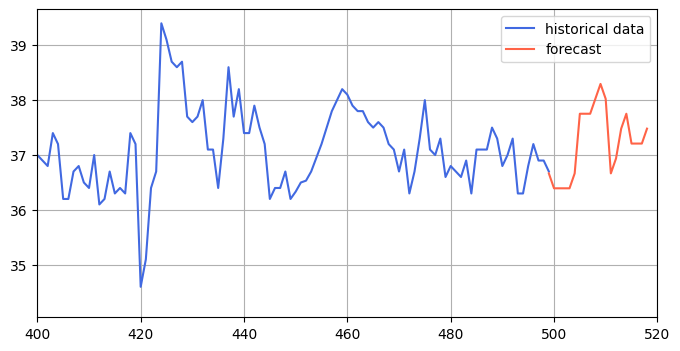

In [214]:
xlim = (CONTEXT_LENGTH-100, CONTEXT_LENGTH+PREDICTION_LENGTH)
# xlim = None
visualize(torch.tensor(physionet_2012_timeseries[i:i+CONTEXT_LENGTH]), prediction, xlim=xlim)